# Processing and Cleaning of Experimental Data

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from itertools import product

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from fittingUtils import PlotData

# Format plot
sns.set(style="white",
        rc={'figure.figsize':(12,6), 'xtick.labelsize': 22, 'ytick.labelsize': 22})

In [23]:
# Environment
dataDir = "./data"

# Plotting
cellLineColorDic = {'OVCAR3':'#55A868', 'OVCAR4':'#C65357'}
cellLineMarkerDic = {'OVCAR3':'s', 'OVCAR4':'P'}

## Continuous Treatment at Varying Doses and Densities

### Clean and format data

In [24]:
# Repeated experiment twice, once where medium was changed every 3d and once where it was changed every 1d.
# For analysis shown in paper will use data collected every 3d.
collectionFrequency = 3
dataDf_DRAssay = pd.read_csv(os.path.join(dataDir,"continuousTreatmentDf_raw.csv"),index_col=0)
dataDf_DRAssay = dataDf_DRAssay[dataDf_DRAssay.CollectionFrequency==collectionFrequency]
dataDf_DRAssay.rename(columns={"DrugDose":"DrugConcentration"},inplace=True)
dataDf_DRAssay = dataDf_DRAssay[np.isin(dataDf_DRAssay.CellLine,["OVCAR3", "OVCAR4"])]
dataDf_DRAssay['Time'] /= 24 # Convert from hours to days

# Save
dataDf_DRAssay.to_csv(os.path.join(dataDir,"continuousTreatmentDf_cleaned.csv"))

### Plot for an overview

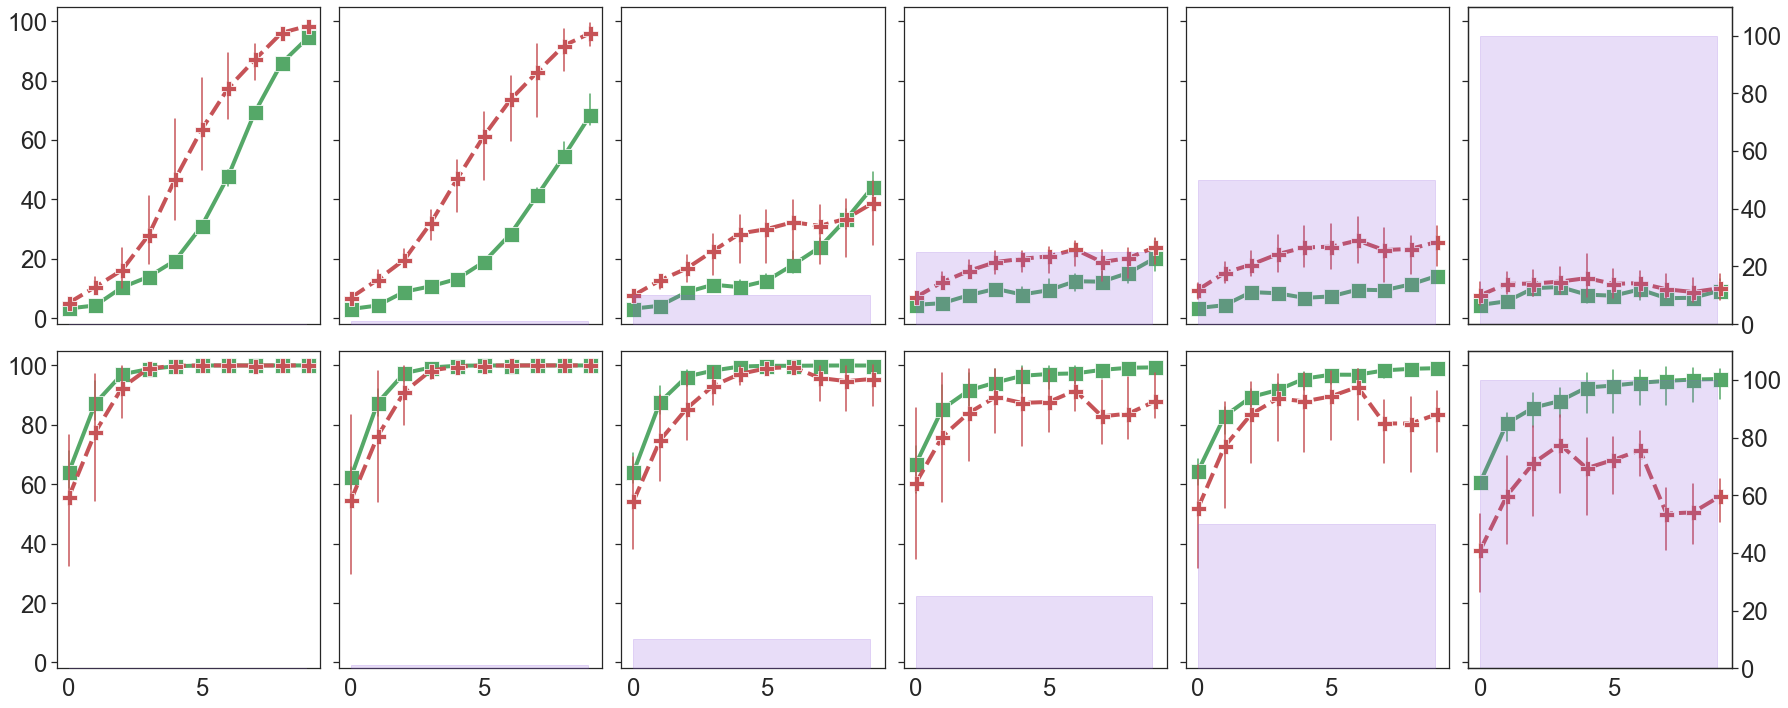

In [26]:
fig, axList = plt.subplots(2,6,sharex=True,sharey=True,figsize=(25,10))
for i,seedingDensity in enumerate(dataDf_DRAssay.SeedingDensity.unique()):
    for j,drugConcentration in enumerate(dataDf_DRAssay.DrugConcentration.unique()):
        currData = dataDf_DRAssay[(dataDf_DRAssay.SeedingDensity==seedingDensity) & 
                          (dataDf_DRAssay.DrugConcentration==drugConcentration)]
        currAx = axList[i][j]
        ax2 = currAx.twinx()  # instantiate a second axes that shares the same x-axis
        tVec = np.arange(0,currData.TimeInDays.max(),0.1)
        ax2.fill_between(tVec,np.repeat(drugConcentration,len(tVec)),
                        color="#8f59e0", alpha=0.2, label="Drug Concentration")
        sns.lineplot(x="TimeInDays", y="Confluence", 
                     hue='CellLine',style='CellLine',
                     err_style="bars", ci=95,
                     palette=cellLineColorDic,
                     markers=cellLineMarkerDic,
                     lw=4, markersize=15,
                     data=currData, legend=False, #'full' if i==0 and j==5  else None,
                     ax=currAx)
        ax2.set_ylim(0,110)
#         currAx.set_xlim(0,10)
        if drugConcentration==100:
            ax2.set_ylabel("")
        else:
            ax2.axis("off")
        currAx.set_ylabel("")
        currAx.set_xlabel("")
        currAx.set_title("")
        currAx.tick_params(labelsize=24)
        ax2.tick_params(labelsize=24)
plt.tight_layout()
# plt.savefig("./figures/doseResponsePlot_timeSeries_all.pdf")

## Intermittent Treatment Data

### Clean and format data

In [27]:
# The experiments were conducted on separate plates. Merge data into a single data frame for ease of 
# handling during the analysis.
delayDataFiles = {"OVCAR3":os.path.join(dataDir,"intermittentTreatmentDf_oc3_raw.csv"),
                  "OVCAR4":os.path.join(dataDir,"intermittentTreatmentDf_oc4_raw.csv")}

tmpList = []
for cellLine in ["OVCAR3","OVCAR4"]:
    # Load data
    tmpDf = pd.read_csv(delayDataFiles[cellLine],index_col=0)
    
    # Clean data by removing erroneous measurements
    if cellLine=="OVCAR3":
        # Remove measurements were I accidentally pipetted out cells
        tmpDf['Time'] /= 24
        tmpDf.loc[(tmpDf.Delay==7) & (tmpDf.DMax==100) &
                  (tmpDf.ReplicateId==3), 'Confluence'] = np.nan
    if cellLine=="OVCAR4":
        # Remove measurements were I accidentally pipetted out cells
        tmpDf.loc[(tmpDf.Delay<2) & (tmpDf.Time>13) &
          (tmpDf.Confluence<95), 'Confluence'] = np.nan

        # OC4 measurements under CT are spurious after about 13-14d, confounded by the build-up of debris
        # from dead cells. Cells actually seen under the microscope are typically dead, and the suggested
        # "regrowth" is due to this debris. To avoid this confounding the analysis, we ignored 
        # these measurements >40% after day 12 and all measurements after day 14.
        tmpDf.loc[(tmpDf.Delay==100) & (tmpDf.Time>13) &
                  (tmpDf.Confluence>40), 'Confluence'] = np.nan
        # In addition, data points at the end of MTD treatment, suggesting that the cells regrow, are not correct.
        # Most of those cells were dead, the "regrowth" is due to debris. Remove those measurements.
        tmpDf.loc[(tmpDf.Delay==100) & (tmpDf.Time>15) & (tmpDf.DMax==100), 'Confluence'] = np.nan

    tmpDf = tmpDf[tmpDf.Time<22].copy() # Limit analysis to 21 days. Beyond that not sure I still trust the measurements
    tmpDf['CellLine'] = cellLine
    tmpList.append(tmpDf)
    
# Save for use in analysis
delayDataDf = pd.concat(tmpList)
delayDataDf.to_csv(os.path.join(dataDir,"intermittentTreatmentDf_cleaned.csv"))

### Plot for an overview

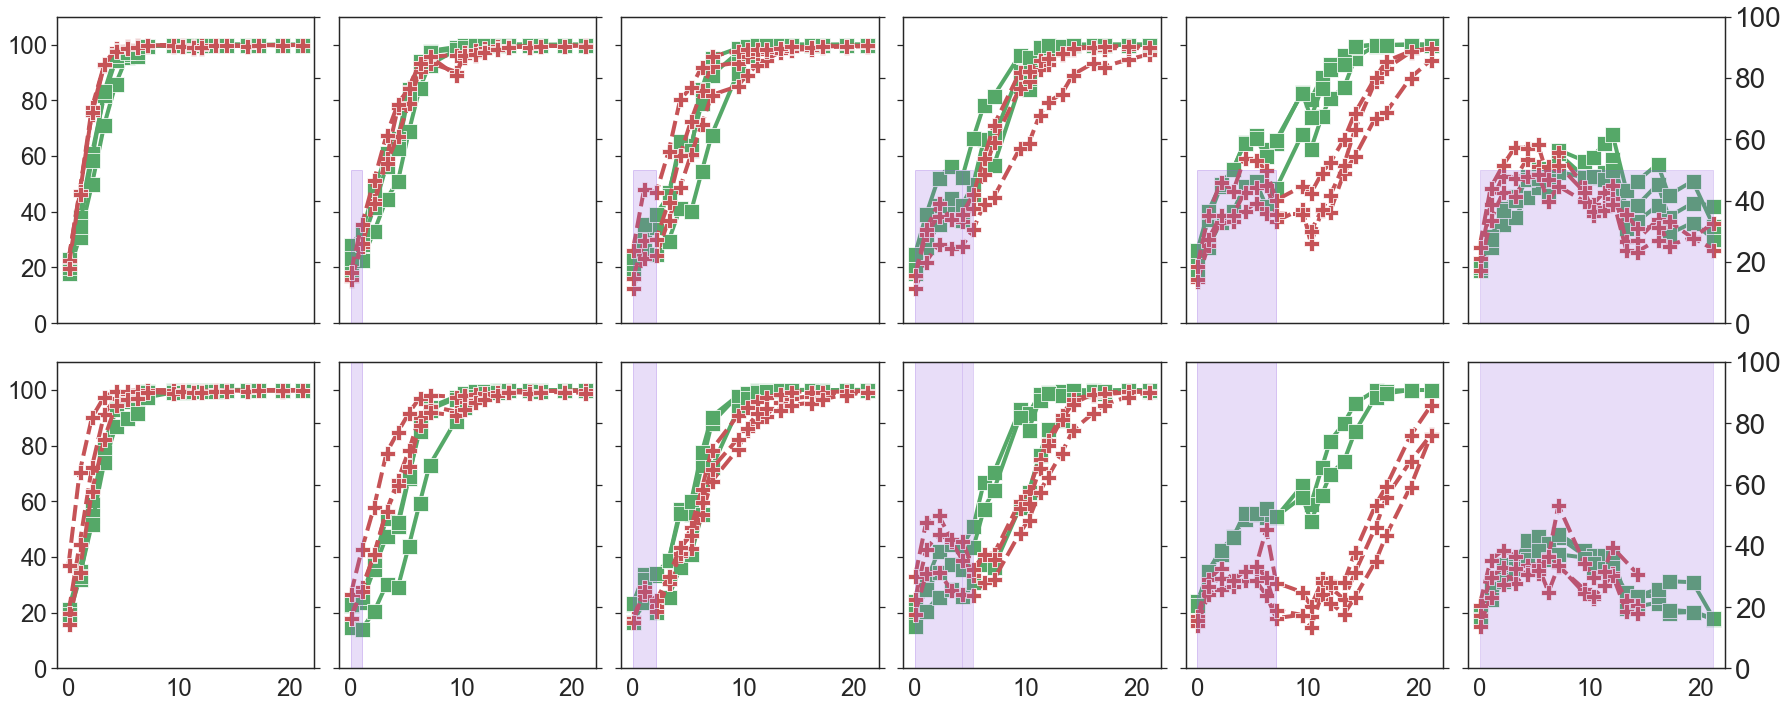

In [28]:
# Plot
fig, axList = plt.subplots(2,6,sharex=True,sharey=True,figsize=(25,10))
for i,DMax in enumerate(delayDataDf.DMax.unique()):
    for j,delay in enumerate(delayDataDf.Delay.unique()):
        currData = delayDataDf[(delayDataDf.DMax==DMax) & 
                                   (delayDataDf.Delay==delay)]
        currAx = axList[i][j]
        sns.lineplot(x="Time",y="Confluence",err_style='bars', units="ReplicateId", estimator=None,
                     hue='CellLine', style='CellLine',
                     palette=cellLineColorDic,
                     markers=cellLineMarkerDic,
                     lw=4, markersize=15,
                     legend=False,
                     data=currData,ax=currAx)
        tmpDf = currData[currData.Delay==delay].copy()
        tmpDf.Confluence = np.nan
        PlotData(tmpDf, ylim=110, decorateY2=delay==100, ax=currAx)
        currAx.set_ylabel("")
        currAx.set_xlabel("")
        currAx.set_title("")
        currAx.tick_params(labelsize=24)
plt.tight_layout()